In [31]:
import pickle
from utils import compute_confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [32]:
# TODO: Ideally, this would be all of the jobs, not just the ones that have run successfully.
y_train, y_val = np.load("out/y_train.npy"), np.load("out/y_val.npy")
train_classes, val_classes = np.unique(y_train), np.unique(y_val)

jobs = {
    "knn" : [1, 2, 3, 4, 5, 6, 7, 8, 9],
    "lr" : [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 12, 13 ,14]
}

acc = {}
precision = {}
recall = {}
f1_scores = {}

In [35]:
def compute_f1(confusion_matrix, val_classes):
    prec = np.zeros(len(val_classes))
    rec = np.zeros(len(val_classes))
    f1 = np.zeros(len(val_classes))
        
    diagonal = np.diag(confusion_matrix)
    row_sums = np.sum(confusion_matrix, axis=1)
    column_sums = np.sum(confusion_matrix, axis=0)

    for i, class_ in enumerate(val_classes):
        rec[i] = diagonal[class_] / row_sums[class_]
        
        if column_sums[class_] == 0:
            prec[i] = 1
        else:
            prec[i] = diagonal[class_] / column_sums[class_]
            
        if prec[i] + rec[i] == 0:
            f1[i] = 0
        else:
            f1[i] = 2 * prec[i] * rec[i] / (prec[i] + rec[i])
        
    return prec, rec, f1

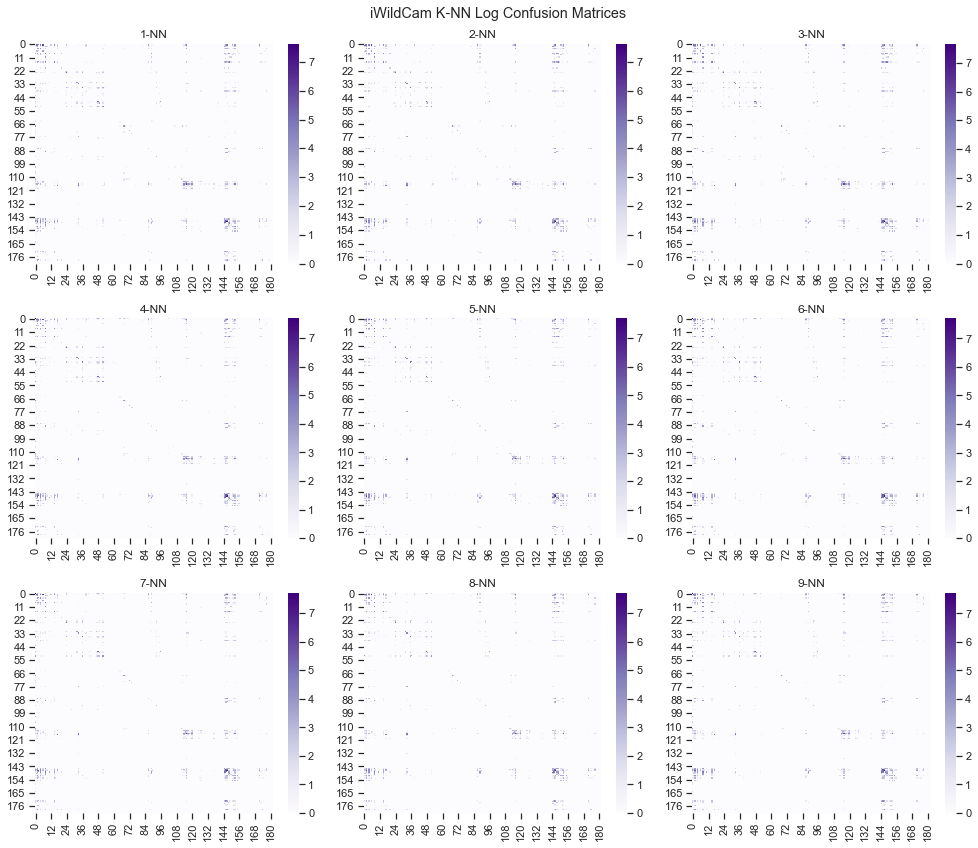

In [36]:
model = "knn"
n_jobs = len(jobs[model])

sns.set(font_scale = 1)
sns.set_style("ticks")
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['figure.figsize'] = [14, 12]

fig, axes = plt.subplots(3, 3)

acc[model] = np.zeros(n_jobs)
precision[model] = np.zeros((n_jobs, len(val_classes)))
recall[model] = np.zeros((n_jobs, len(val_classes)))
f1_scores[model] = np.zeros((n_jobs, len(val_classes)))

for i, job in enumerate(jobs[model]):
    
    # Compute confusion matrix.
    y_pred = pickle.load(open("out/%s_y_pred_%d.p" % (model, job), "rb"))
    conf_mat = compute_confusion_matrix(y_pred)
    
    # Compute accuracy, precision, recall, and f1.
    acc[model][i] = np.trace(conf_mat) / np.sum(conf_mat)
    precision[model][i, :], recall[model][i, :], f1_scores[model][i, :] = compute_f1(conf_mat, val_classes)
    
    # Plot.
    ax = axes[i // 3, i % 3]
    mat = np.log(conf_mat + 1)
    title = "%d-NN" % job
    
    sns.heatmap(mat, cmap="Purples", ax = ax)
    ax.set_title(title)
    
fig.suptitle("iWildCam K-NN Log Confusion Matrices")
plt.tight_layout()
plt.savefig("figs/knn_conf_mat.pdf", bbox_inches="tight")
plt.show()

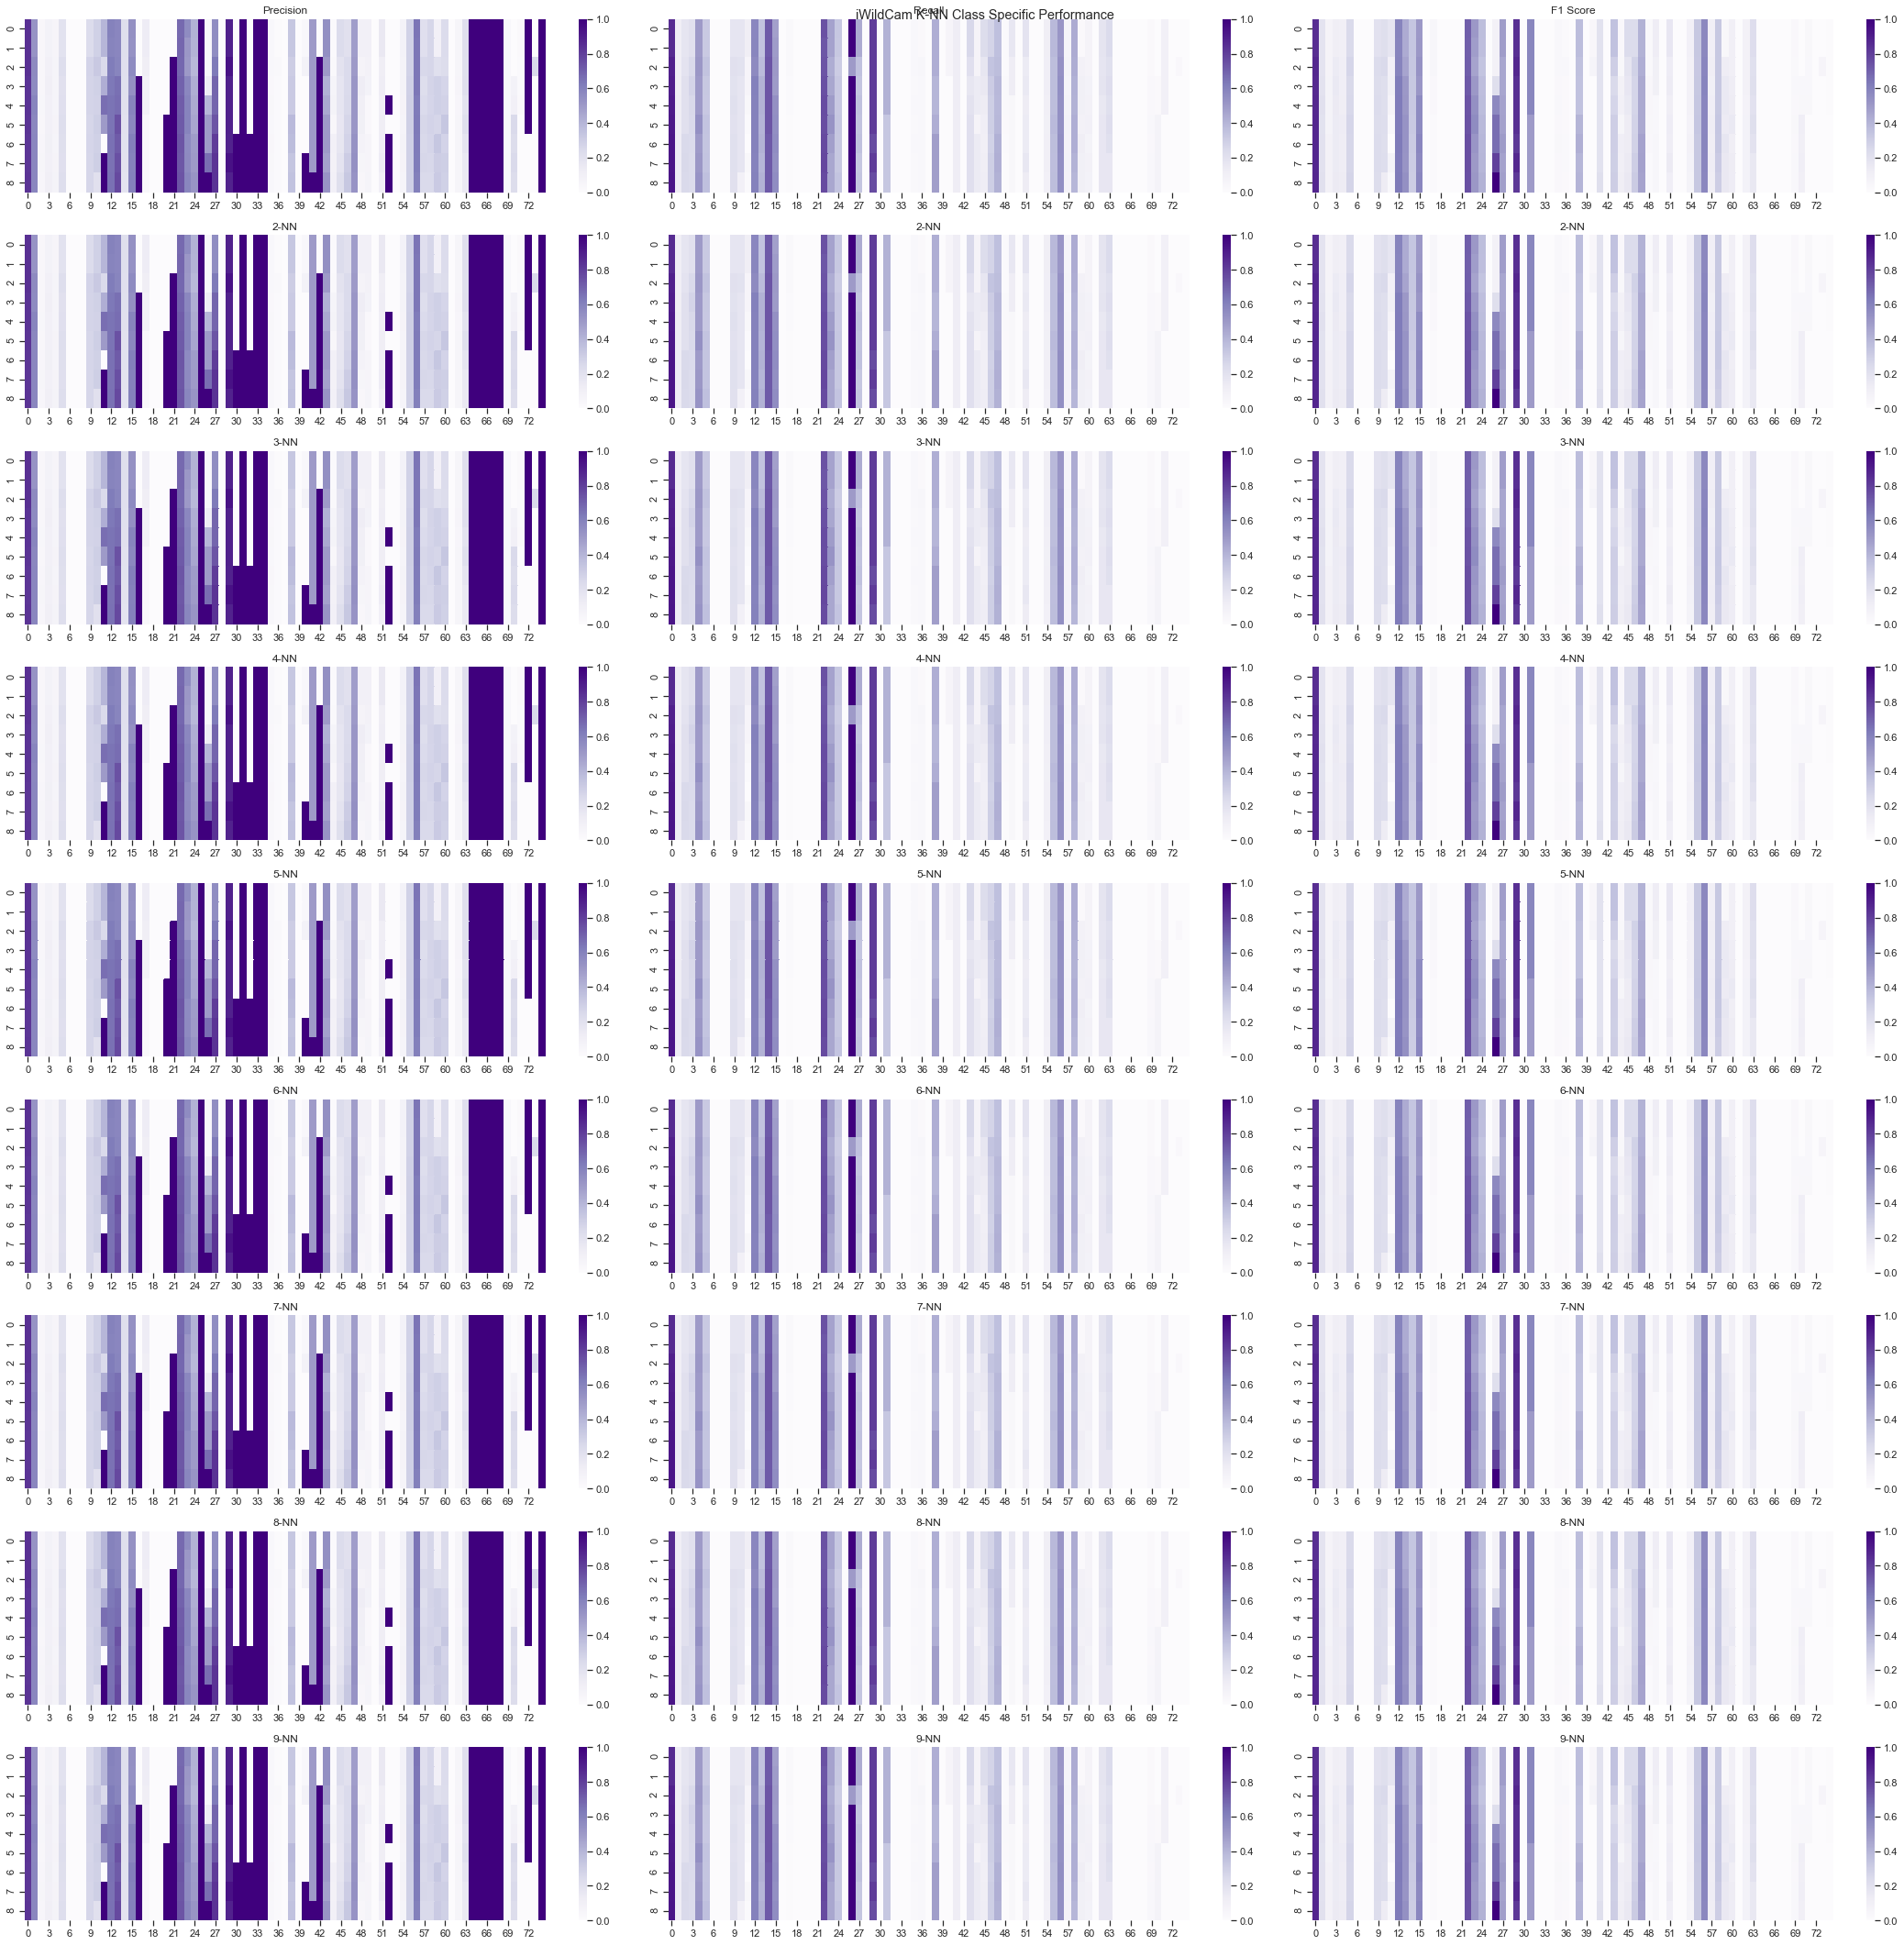

In [43]:
model = "knn"
n_jobs = len(jobs[model])

sns.set(font_scale = 1)
sns.set_style("ticks")
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['figure.figsize'] = [30, 30]

fig, axes = plt.subplots(9, 3)

metrics = [precision[model], recall[model], f1_scores[model]]
for i, job in enumerate(jobs[model]):
    for j, metric in enumerate(metrics):
        
        ax = axes[i, j]
        mat = metric
        title = "%d-NN" % job
        
        sns.heatmap(mat, cmap="Purples", ax = ax)
        ax.set_title(title)
        
axes[0, 0].set_title("Precision")
axes[0, 1].set_title("Recall")
axes[0, 2].set_title("F1 Score")

fig.suptitle("iWildCam K-NN Class Specific Performance")
plt.tight_layout()
plt.savefig("figs/%s_class_perf.pdf" % model, bbox_inches="tight")
plt.show()

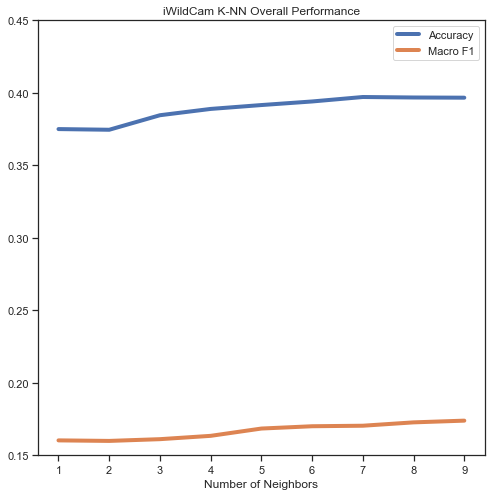

In [53]:
macro_f1 = []
for i, job in enumerate(jobs[model]):
    macro_f1.append(f1_scores[model][i].mean())
    
plt.title("iWildCam K-NN Overall Performance")
plt.rcParams['figure.figsize'] = [8, 8]
plt.ylim(0.15, 0.45)

plt.plot(jobs[model], acc[model], linewidth=4, label="Accuracy")
plt.plot(jobs[model], macro_f1, linewidth=4, label="Macro F1")

plt.xlabel("Number of Neighbors")
plt.legend()
plt.savefig("figs/%s_perf.pdf" % model, bbox_inches="tight")
plt.show()

In [54]:
with open("%s_metrics/accuracy.npy" % model, "wb") as f:
    np.save(f, acc[model])
with open("%s_metrics/precision.npy" % model, "wb") as f:
    np.save(f, precision[model])
with open("%s_metrics/recall.npy" % model, "wb") as f:
    np.save(f, recall[model])
with open("%s_metrics/f1.npy" % model, "wb") as f:
    np.save(f, f1_scores[model])